In [1]:
print('hello')

hello


In [2]:
# import numpy as np

In [3]:
#!pip install -q "tensorflow==2.11.*"
# tensorflow_io 0.28 is compatible with TensorFlow 2.11
#pip install -q "tensorflow_io==0.28.*"

In [4]:
#%pip install --upgrade tensorflow-io[tensorflow]
# %pip install tensorflow==2.16.2
# %pip install tensorflow-io==0.37.1

In [5]:
# !pip show tensorflow

In [6]:
import os

from IPython import display
#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio


C:\Users\sunde\Downloads\Anaconda\envs\transfer_learning\lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [7]:
import matplotlib.pyplot as plt

In [8]:
# import tensorflow_io as tfio

In [9]:
print(tf.__version__)


2.11.0


In [10]:
yamnet_model_handle='https://tfhub.dev/google/yamnet/1'
yamnet_model=hub.load(yamnet_model_handle)

In [11]:
testing_wav_file_name=tf.keras.utils.get_file('miaow_16k.wav',
                                              'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                              cache_dir="./",
                                              cache_subdir="test_data")
print(testing_wav_file_name)

./test_data\miaow_16k.wav


 **Need a function to load audio files, which will also be used later when working with the training data.** 

**: The returned wav_data from load_wav_16k_mono is already normalized to values in the [-1.0, 1.0] range**

In [12]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents=tf.io.read_file(filename)
    wav,sample_rate=tf.audio.decode_wav(file_contents,desired_channels=1)
    print(sample_rate)
    wav=tf.squeeze(wav,axis=-1)
    sample_rate=tf.cast(sample_rate,dtype=tf.int64)
    wav=tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)
    return wav

Tensor("DecodeWav:1", shape=(), dtype=int32)
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


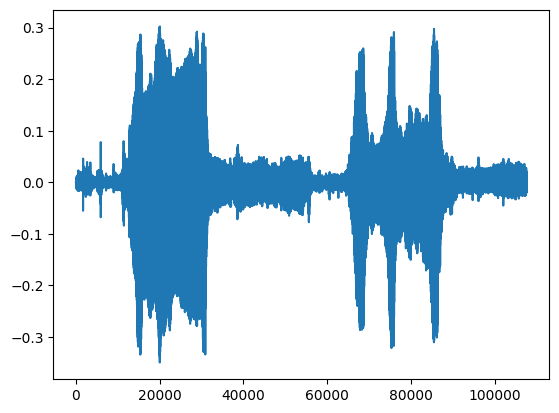

In [13]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)
_=plt.plot(testing_wav_data)
display.Audio(testing_wav_data,rate=16000)

**Load the class mapping**

**It's important to load the class names that YAMNet is able to recognize. The mapping file is present at yamnet_model.class_map_path() in the CSV format.**

In [14]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
Baby cry, infant cry
Whimper
Wail, moan
Sigh
Singing
Choir
Yodeling
Chant
Mantra
Child singing
Synthetic singing
Rapping
Humming
Groan
Grunt
Whistling
Breathing
Wheeze
Snoring
Gasp
Pant
Snort
Cough
Throat clearing
Sneeze
Sniff
Run
Shuffle
Walk, footsteps
Chewing, mastication
Biting
Gargling
Stomach rumble
Burping, eructation
Hiccup
Fart
Hands
Finger snapping
Clapping
Heart sounds, heartbeat
Heart murmur
Cheering
Applause
Chatter
Crowd
Hubbub, speech noise, speech babble
Children playing
Animal
Domestic animals, pets
Dog
Bark
Yip
Howl
Bow-wow
Growling
Whimper (dog)
Cat
Purr
Meow
Hiss
Caterwaul
Livestock, farm animals, working animals
Horse
Clip-clop
Neigh, whinny
Cattle, bovinae
Moo
Cowbell
Pig
Oink
Goat
Bleat
Sheep
Fowl
Chicken, rooster
Cluck
Crowi

**Classes to watch out for :Glass , Smash, crash ,Breaking ,Crushing**

**YAMNet provides frame-level class-scores (i.e., 521 scores for every frame). In order to determine clip-level predictions, the scores can be aggregated per-class across frames (e.g., using mean or max aggregation). This is done below by scores_np.mean(axis=0). Finally, to find the top-scored class at the clip-level, you take the maximum of the 521 aggregated scores.**

In [15]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Animal
The embeddings shape: (13, 1024)


**Goal in this tutorial is to increase the model's accuracy for specific classes. Also, notice that the model generated 13 embeddings, 1 per frame.**

**Glass break dataset :  is a labeled collection of 417 one-second long glass_break and background audio recordings. The dataset consists of 2 classes, with 200+ examples per class.**

**Explore the data:**

**The metadata for each file is specified in the csv file at /meta/esc50.csv and all the audio files are in /audio/**

In [16]:
esc50_csv = 'meta\esc50.csv'
base_data_path = 'audio'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-000001-A-0.wav,1,0,background,False,Background.cbor.5s58tmo3.ingestion-6d4bc445b6-...,A
1,2-000002-A-0.wav,2,0,background,False,Background.cbor.5s5738uc.ingestion-6d4bc445b6-...,A
2,3-000003-A-0.wav,3,0,background,False,Background.cbor.5s81vdgp.ingestion-7d97fcc65d-...,A
3,4-000004-A-0.wav,4,0,background,False,Background.cbor.5s5b7s9i.ingestion-6d4bc445b6-...,A
4,5-000005-A-0.wav,5,0,background,False,Background.cbor.5s5ajeur.ingestion-6d4bc445b6-...,A


In [17]:
my_classes = ['background', 'glass_break']
map_class_to_id = {'background':0, 'glass_break':1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
0,audio\1-000001-A-0.wav,1,0,background,False,Background.cbor.5s58tmo3.ingestion-6d4bc445b6-...,A
1,audio\2-000002-A-0.wav,2,0,background,False,Background.cbor.5s5738uc.ingestion-6d4bc445b6-...,A
2,audio\3-000003-A-0.wav,3,0,background,False,Background.cbor.5s81vdgp.ingestion-7d97fcc65d-...,A
3,audio\4-000004-A-0.wav,4,0,background,False,Background.cbor.5s5b7s9i.ingestion-6d4bc445b6-...,A
4,audio\5-000005-A-0.wav,5,0,background,False,Background.cbor.5s5ajeur.ingestion-6d4bc445b6-...,A
5,audio\1-000006-A-0.wav,1,0,background,False,Background.cbor.5s57000n.ingestion-6d4bc445b6-...,A
6,audio\2-000007-A-0.wav,2,0,background,False,Background.cbor.5s5ajuvj.ingestion-6d4bc445b6-...,A
7,audio\3-000008-A-0.wav,3,0,background,False,Background.cbor.5s58silh.ingestion-6d4bc445b6-...,A
8,audio\4-000009-A-0.wav,4,0,background,False,Background.cbor.5s5af4tr.ingestion-6d4bc445b6-...,A
9,audio\5-000010-A-0.wav,5,0,background,False,Background.cbor.5s80k542.ingestion-7d97fcc65d-...,A


**Load the audio files and retrieve embeddings**

In [18]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [19]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

Tensor("DecodeWav:1", shape=(), dtype=int32)


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [20]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

**Split the data**

**You will use the fold column to split the dataset into train, validation and test sets.**

**ESC-50 is arranged into five uniformly-sized cross-validation folds, such that clips from the same original source are always in the same fold** 

**The last step is to remove the fold column from the dataset since you're not going to use it during training.**



In [21]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [23]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [24]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
16/16 [==============================] - 8s 84ms/step - loss: 0.2614 - accuracy: 0.9283 - val_loss: 0.1053 - val_accuracy: 0.9819
Epoch 2/20
16/16 [==============================] - 0s 6ms/step - loss: 0.0793 - accuracy: 0.9761 - val_loss: 0.1043 - val_accuracy: 0.9639
Epoch 3/20
16/16 [==============================] - 0s 5ms/step - loss: 0.0585 - accuracy: 0.9841 - val_loss: 0.1277 - val_accuracy: 0.9518
Epoch 4/20
16/16 [==============================] - 0s 6ms/step - loss: 0.0467 - accuracy: 0.9861 - val_loss: 0.1268 - val_accuracy: 0.9518
Epoch 5/20
16/16 [==============================] - 0s 6ms/step - loss: 0.0373 - accuracy: 0.9900 - val_loss: 0.1276 - val_accuracy: 0.9578
Epoch 6/20
16/16 [==============================] - 0s 5ms/step - loss: 0.0287 - accuracy: 0.9920 - val_loss: 0.1382 - val_accuracy: 0.9518
Epoch 7/20
16/16 [==============================] - 0s 5ms/step - loss: 0.0236 - accuracy: 0.9940 - val_loss: 0.1432 - val_accuracy: 0.9578
Epoch 8/20
16/16 [=

In [25]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

6/6 [==============================] - 0s 7ms/step - loss: 0.1240 - accuracy: 0.9578
Loss:  0.1240365281701088
Accuracy:  0.9578313231468201


In [26]:
import os
#C:\Users\sunde\Downloads\Glass_break_sound_classification_using_transfer_learning\audio\5-000415-A-1.wav
# Define the relative path to your file
relative_file_path = os.path.join("audio", "5-000415-A-1.wav")

# tf.keras.utils.get_file is not needed here.
testing_wav_file_name1 = relative_file_path

print(testing_wav_file_name1)


audio\5-000415-A-1.wav


Tensor("DecodeWav:1", shape=(), dtype=int32)


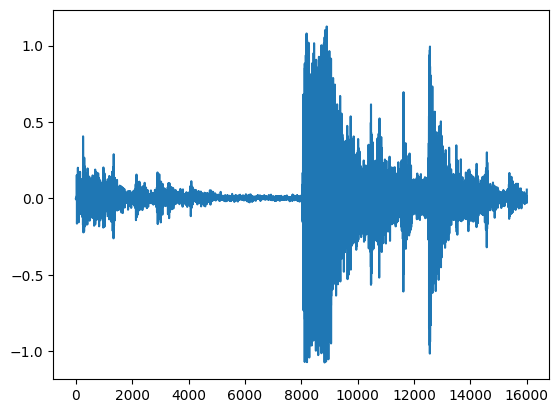

In [27]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name1)
_=plt.plot(testing_wav_data)
display.Audio(testing_wav_data,rate=16000)

In [28]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: glass_break


**Save a model that can directly take a WAV file as input**

In [29]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [30]:
saved_model_path = './glass_break_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./glass_break_yamnet\assets


INFO:tensorflow:Assets written to: ./glass_break_yamnet\assets


In [39]:
# tf.keras.utils.plot_model(serving_model)A

In [36]:
reloaded_model = tf.saved_model.load("glass_break_yamnet")

In [37]:
reloaded_results = reloaded_model(testing_wav_data)
bg_or_glass = my_classes[tf.math.argmax(reloaded_results)]
print(f'The main sound is: {bg_or_glass}')

The main sound is: glass_break


audio\5-000100-A-0.wav
Tensor("DecodeWav:1", shape=(), dtype=int32)


Waveform values: [ 9.4868807e-07 -2.9481562e-06  7.2493972e-06 ...  2.6677921e-02
  1.5491076e-02  1.4818177e-02]


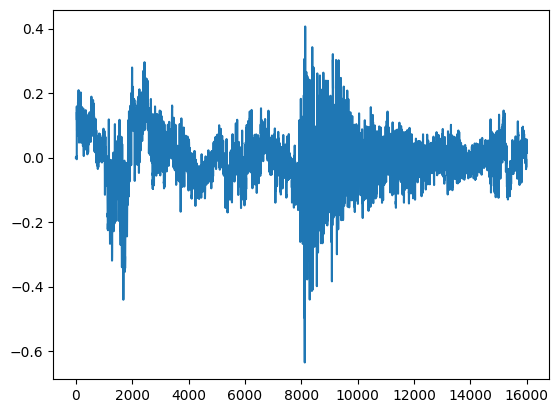

In [40]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 5]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [41]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {inferred_class} ({top_score})')

reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')

[YAMNet] The main sound is: Thump, thud (0.47959646582603455)
[Your model] The main sound is: background (0.95354825258255)
